In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import random
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Environment



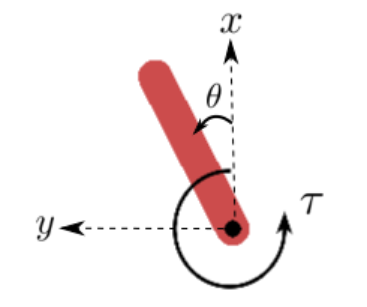


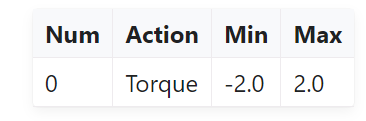


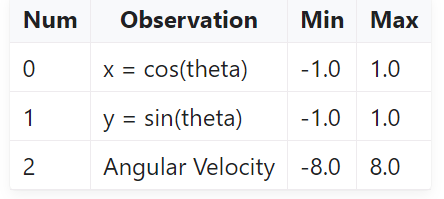

# Twin Delayed Deep Deterministic Policy Gradients (TD3)

![Alt text](image.png)

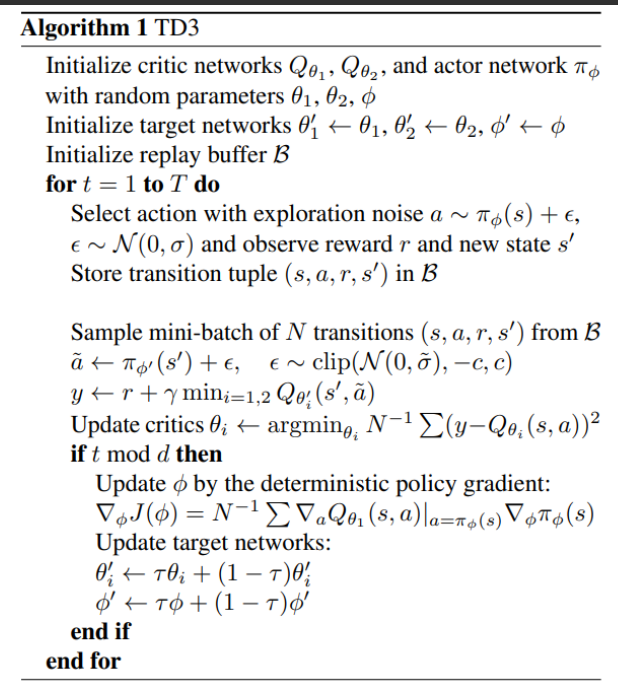

In [2]:
class Actor(tf.keras.Model):
    def __init__(self, no_actions, layer1_dim, layer2_dim):
        super(Actor,self).__init__()
        self.layer1 = tf.keras.layers.Dense(layer1_dim, activation='relu')
        self.layer2 = tf.keras.layers.Dense(layer2_dim, activation='relu')
        self.out = tf.keras.layers.Dense(no_actions, activation='tanh')
    def call(self,states):
        lay1_out = self.layer1(states)
        lay2_out = self.layer2(lay1_out)
        out = self.out(lay2_out)
        return out

class Critic(tf.keras.Model):
    def __init__(self, layer1_dim, layer2_dim):
        super(Critic,self).__init__()
        self.layer1 = tf.keras.layers.Dense(layer1_dim, activation='relu')
        self.layer2 = tf.keras.layers.Dense(layer2_dim, activation='relu')
        self.critic_qval = tf.keras.layers.Dense(1, activation=None)
    def call(self,states,actions):
        lay1_out = self.layer1(tf.concat([states, actions], axis=1))
        lay2_out = self.layer2(lay1_out)
        critic_qval = self.critic_qval(lay2_out)
        return critic_qval


In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        action = tf.convert_to_tensor(action, dtype=tf.float32)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)
        next_state = tf.convert_to_tensor(next_state, dtype=tf.float32)
        done = tf.convert_to_tensor(done, dtype=tf.float32)
        return state, action, tf.expand_dims(reward, 1), next_state, tf.expand_dims(done, 1)

In [3]:
class TD3_Agent:
    def __init__(self, no_actions, gamma, buf_capacity, noise, env, batch_size, actor_lr, critic_lr,update_freq, layer1_dim, layer2_dim):
        self.actor = Actor(no_actions,layer1_dim, layer2_dim)
        self.critic1 = Critic(layer1_dim, layer2_dim)
        self.critic2 = Critic(layer1_dim, layer2_dim)

        self.actor_target = Actor(no_actions,layer1_dim, layer2_dim)
        self.critic1_target = Critic(layer1_dim, layer2_dim)
        self.critic2_target = Critic(layer1_dim, layer2_dim)

        self.gamma = gamma
        self.tau = tau
        self.noise = noise
        self.batch_size = batch_size
        self.replaybuffer = ReplayBuffer(buf_capacity)
        self.env = env
        self.update_freq = update_freq

        self.actor_target.set_weights(self.actor.get_weights())
        self.critic1_target.set_weights(self.critic1.get_weights())
        self.critic2_target.set_weights(self.critic2.get_weights())

        self.actor.compile(optimizer=Adam(learning_rate=actor_lr), loss='mean')
        self.actor_target.compile(optimizer=Adam(learning_rate=actor_lr), loss='mean')
        self.critic1.compile(optimizer=Adam(learning_rate=critic_lr), loss='mean_squared_error')
        self.critic2.compile(optimizer=Adam(learning_rate=critic_lr), loss='mean_squared_error')
        self.critic1_target.compile(optimizer=Adam(learning_rate=critic_lr), loss='mean_squared_error')
        self.critic2_target.compile(optimizer=Adam(learning_rate=critic_lr), loss='mean_squared_error')

    def choose_action(self, state):
        if self.noise != 0:
            state = tf.convert_to_tensor([state], dtype=tf.float32)
            action = self.actor(state)[0]
            action = action + np.random.normal(scale=self.noise)
            action = tf.clip_by_value(action, self.env.action_space.low[0],
                              self.env.action_space.high[0])
            return action

    def train(self, current_timestep):
        if len(self.replaybuffer.buffer) >= self.batch_size:
            states, actions, rewards, next_states, dones = self.replaybuffer.sample(self.batch_size)
            target_actions = self.actor_target(next_states) + tf.clip_by_value(np.random.normal(scale=self.noise), -0.5, 0.5)
            target_actions = tf.clip_by_value(target_actions, self.env.action_space.low[0], self.env.action_space.high[0])

            with tf.GradientTape(persistent=True) as tape:
                target_cq1 = tf.squeeze(self.critic1_target(next_states,target_actions),1)
                target_cq2 = tf.squeeze(self.critic2_target(next_states,target_actions),1)
                target_cq = tf.math.minimum(target_cq1,target_cq2)
                y = rewards + (1-dones)*self.gamma*target_cq
                critic1_q = tf.squeeze(self.critic1(states,actions),1)
                critic2_q = tf.squeeze(self.critic2(states,actions),1)
                critic1_loss = tf.keras.losses.MSE(y, critic1_q)
                critic2_loss = tf.keras.losses.MSE(y, critic2_q)

            critic1_gradient = tape.gradient(critic1_loss, self.critic1.trainable_variables)
            critic2_gradient = tape.gradient(critic2_loss, self.critic2.trainable_variables)
            self.critic1.optimizer.apply_gradients(zip(critic1_gradient, self.critic1.trainable_variables))
            self.critic2.optimizer.apply_gradients(zip(critic2_gradient, self.critic2.trainable_variables))

            if current_timestep % self.update_freq == 0:
                with tf.GradientTape() as tape:
                    actor_loss = -tf.math.reduce_mean(self.critic1(states,self.actor(states)))
                actor_gradient = tape.gradient(actor_loss, self.actor.trainable_variables)
                self.actor.optimizer.apply_gradients(zip(actor_gradient, self.actor.trainable_variables))

                for act, tar_act in zip(self.actor.trainable_variables, self.actor_target.trainable_variables):
                    tar_act.assign((1 - self.tau) * tar_act + self.tau * act)

                for crt1, tar_crt1 in zip(self.critic1.trainable_variables, self.critic1_target.trainable_variables):
                    tar_crt1.assign((1 - self.tau) * tar_crt1 + self.tau * crt1)

                for crt2, tar_crt2 in zip(self.critic2.trainable_variables, self.critic2_target.trainable_variables):
                    tar_crt2.assign((1 - self.tau) * tar_crt2 + self.tau * crt2)

/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 Cumulative Episode Reward: -795.538178156475
Episode: 50 Cumulative Episode Reward: -1033.5306328366255
Episode: 100 Cumulative Episode Reward: -1067.7698135005824
Episode: 150 Cumulative Episode Reward: -1781.2690785573639
Episode: 200 Cumulative Episode Reward: -1860.4980243902378
Episode: 250 Cumulative Episode Reward: -972.5788300210231
Episode: 300 Cumulative Episode Reward: -890.1162937999779
Episode: 350 Cumulative Episode Reward: -890.8864694425314
Episode: 400 Cumulative Episode Reward: -921.1110451352907
Episode: 450 Cumulative Episode Reward: -1037.441838218027
Episode: 500 Cumulative Episode Reward: -887.16861904597
Episode: 550 Cumulative Episode Reward: -859.8874656260471
Episode: 600 Cumulative Episode Reward: -860.091577457608
Episode: 650 Cumulative Episode Reward: -1722.9716823378642
Episode: 700 Cumulative Episode Reward: -964.4334457201137
Episode: 750 Cumulative Episode Reward: -819.8107205188899
Episode: 800 Cumulative Episode Reward: -766.1874169795665

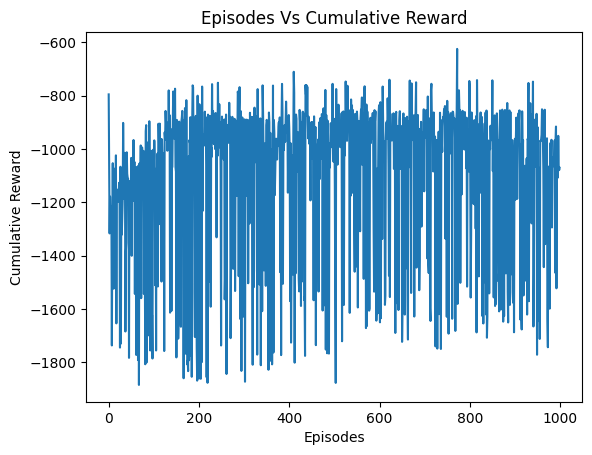

In [7]:
env = gym.make("Pendulum-v1")
no_actions = env.action_space.shape[0]
dis_fac = 0.99
episodes = 1000
noise = 0.1
tau = 0.005
batch_size = 100
actor_lr = 0.001
critic_lr = 0.001
max_timesteps = 200
layer1_dim = 400
layer2_dim = 300
td3_agent = TD3_Agent(no_actions=no_actions, gamma = dis_fac, buf_capacity = 100000, env = env, noise = noise, batch_size = batch_size,
                      actor_lr = actor_lr, critic_lr = critic_lr, update_freq = 2, layer1_dim= layer1_dim, layer2_dim= layer2_dim)
rewards = []


for i in range(episodes):
    state,_ = env.reset()
    reward_episode = 0
    done = False
    current_timestep = 0
    while current_timestep <= max_timesteps and not done:
        action = td3_agent.choose_action(state)
        next_state, reward, terminated, truncated,info = env.step(action)
        done = terminated or truncated
        td3_agent.replaybuffer.push(state, action, reward, next_state, done)
        td3_agent.train(current_timestep)
        state = next_state
        current_timestep += 1
        reward_episode += reward
    rewards.append(reward_episode)
    if i%50 == 0:
        print('Episode:', i, 'Cumulative Episode Reward:', reward_episode)

plt.plot(range(episodes),rewards)
plt.title('Episodes Vs Cumulative Reward')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.show()
